In [441]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity

# My modules
import diffusionstuff11 as ds

In [442]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2

In [443]:
# Functions
def expfun(x,lambda0,x0):
    return lambda0*(1-np.exp(-x/x0))

def get_nu_kin(T,AssignQuantity):
    P3 = AssignQuantity(611,'Pa')
    T3 = AssignQuantity(273,'K')
    R = AssignQuantity(8.314,'J/mol/K')
    M = AssignQuantity(18,'g/mol')
    NA = AssignQuantity(6.02e23,'1/mol')
    rho = AssignQuantity(0.9,'g/cm^3')
    
    # Clausius-Clapeyron
    Delta_H_sub = AssignQuantity(50,'kJ/mol')
    P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/T-1/T3))
    
    # Hertz-Knudsen
    nu_kin = P_vapor_eq*M**.5/(2*np.pi*R*T)**.5
    nu_kin.ito('gram / micrometer ** 2 / second')
    nu_kin /= rho
    nu_kin.ito('micrometer/second')
    return(nu_kin)

def get_D_of_T(T,AssignQuantity):
    """ Based on a log/inverse T fit to Price's data for supercooled liquid water """
    T_inverse_Temperature = 1e3/T; #print(T_inverse_Temperature)
    p = [-2.74653072, 9.97737468]
    logD = np.polyval(p,T_inverse_Temperature.magnitude)
    D = AssignQuantity(np.exp(logD)*1e-5*100,'micrometers^2/microsecond')
    return D

def get_L_cr_of_T(Temperature,AssignQuantity):
    aT = 9.341579E-09
    bT = 9.857504E-02
    L_cr_of_T = aT * np.exp(bT*Temperature.magnitude)
    return L_cr_of_T

def get_L_cr_of_P(Pressure,AssignQuantity): 
    aP = 18041.86122836
    bP = -1.09599342
    L_cr_of_P = aP * Pressure.magnitude**(bP)
    return L_cr_of_P

def get_L_cr_of_TP(Temperature,Pressure,AssignQuantity): 
    L_cr_of_T = get_L_cr_of_T(Temperature,AssignQuantity)
    Temperature_ref = AssignQuantity(240,'K')
    L_cr_of_T_ref = get_L_cr_of_T(Temperature_ref,AssignQuantity)
    L_cr_of_P = get_L_cr_of_P(Pressure,AssignQuantity)
    L_cr_of_TP = L_cr_of_T/L_cr_of_T_ref*L_cr_of_P
    return L_cr_of_TP

def get_cr_of_T(L,Temperature,AssignQuantity): 
    cr = L/get_L_cr_of_T(Temperature,AssignQuantity)
    return cr

def get_cr_of_P(L,Pressure,AssignQuantity): 
    cr = L/get_L_cr_of_P(Pressure,AssignQuantity)
    return cr

def get_cr_of_TP(L,Temperature,Pressure,AssignQuantity):     
#     Temperature_ref = AssignQuantity(240,'K')
#     L_cr_T = get_L_cr_of_T(Temperature,AssignQuantity)
#     L_cr_Tref = get_L_cr_of_T(Temperature_ref,AssignQuantity)
#     L_cr_P = get_L_cr_of_P(Pressure,AssignQuantity)
#     L_cr = L_cr_T/L_cr_Tref*L_cr_P
    L_cr_of_TP = get_L_cr_of_TP(Temperature,Pressure,AssignQuantity)
    cr_of_TP = L/L_cr_of_TP
    return cr_of_TP

# Testing the above formulas
L = AssignQuantity(50,'micrometers')
Pressure = AssignQuantity(68.6,'Pa')
Temperature = AssignQuantity(240,'K')
print('Test 1 (reference case)')
print(get_L_cr_of_P(Pressure,AssignQuantity))
print(get_L_cr_of_T(Temperature,AssignQuantity))
print(get_cr_of_T(L,Temperature,AssignQuantity))
print(get_cr_of_P(L,Pressure,AssignQuantity))
print(get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

print('Test 2 (changing temperature)')
L = AssignQuantity(100,'micrometers')
Pressure = AssignQuantity(68.6,'Pa')
Temperature = AssignQuantity(250,'K')
print(get_L_cr_of_P(Pressure,AssignQuantity))
print(get_L_cr_of_T(Temperature,AssignQuantity))
print(get_cr_of_T(L,Temperature,AssignQuantity))
print(get_cr_of_P(L,Pressure,AssignQuantity))
print(get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

print('Test 3 (changing pressure)')
L = AssignQuantity(50,'micrometers')
Pressure = AssignQuantity(500,'Pa')
Temperature = AssignQuantity(240,'K')
print(get_L_cr_of_P(Pressure,AssignQuantity))
print(get_L_cr_of_T(Temperature,AssignQuantity))
print(get_cr_of_T(L,Temperature,AssignQuantity))
print(get_cr_of_P(L,Pressure,AssignQuantity))
print(get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

print('Test 4 (changing temperature and pressure)')
L = AssignQuantity(50,'micrometers')
Pressure = AssignQuantity(500,'Pa')
Temperature = AssignQuantity(250,'K')
print(get_L_cr_of_P(Pressure,AssignQuantity))
print(get_L_cr_of_T(Temperature,AssignQuantity))
print(get_cr_of_T(L,Temperature,AssignQuantity))
print(get_cr_of_P(L,Pressure,AssignQuantity))
print(get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')


Test 1 (reference case)
175.25975096790899
175.77751197212177
0.2844504933482616 micrometer
0.28529083103145153 micrometer
0.28529083103145153 micrometer

Test 2 (changing temperature)
175.25975096790899
471.0524557440127
0.21229058203730858 micrometer
0.5705816620629031 micrometer
0.2129177413498919 micrometer

Test 3 (changing pressure)
19.871377441811234
175.77751197212177
0.2844504933482616 micrometer
2.5161818875623254 micrometer
2.5161818875623254 micrometer

Test 4 (changing temperature and pressure)
19.871377441811234
471.0524557440127
0.10614529101865429 micrometer
2.5161818875623254 micrometer
0.9389361767925446 micrometer



### The cell below specifies parameters for the 0-d and 1-d runs

In [444]:
#Setting up the system

# Crystal size
L = 50 # micrometers
print('L = ',L)

# This is the temperature
Temperature = AssignQuantity(240,'K')
print('Temperature = ',Temperature)

# This is the pressure
Pressure = AssignQuantity(50,'Pa')
print('Ambient pressure = ',Pressure)

# Temperature- and pressure-dependent center reduction
Iwantcalculated_center_reduction = False
if Iwantcalculated_center_reduction:
    center_reduction = get_cr_of_TP(L,Temperature,Pressure,AssignQuantity)
    print('Calculating a center reduction')
    print('   Lcr = ', L/center_reduction)
    print('   Lcr = ', get_L_cr_of_TP(Temperature,Pressure,AssignQuantity))
    print('   center_reduction = ',center_reduction)
else:
    print('Assigning a center reduction')
    center_reduction = 0.376
    print('   Lcr = ', L/center_reduction)
    print('   center_reduction = ',center_reduction)
c_r = center_reduction/100

# # Temperature-dependent center reduction
# Iwantcalculated_center_reduction = True
# if Iwantcalculated_center_reduction:
#     print('Calculating a center reduction')
#     center_reduction = get_center_reduction(L,Temperature,AssignQuantity)
#     print('   center_reduction = ',center_reduction)
# else:
#     print('Assigning a center reduction')
#     center_reduction = 0.25
#     print('   center_reduction = ',center_reduction)
# c_r = center_reduction/100

# Surface diffusion coefficient
Iwantcalculated_D = True
if Iwantcalculated_D:
    print('Calculating the surface diffusion coefficient')
    D = get_D_of_T(Temperature,AssignQuantity)
    print('   D = ',D)
    D = D.magnitude
else:
    print('Assigning a surface diffusion coefficient')
    D = 1e-3 # micrometers^2/microsecond
    print('   D = ',D)
    
# Kinetic velocity
Iwantcalculated_nu_kin = True
if Iwantcalculated_nu_kin:
    print('Calculating a kinetic velocity')
    nu_kin = get_nu_kin(Temperature,AssignQuantity)
    print('   nu_kin = ',nu_kin)
    nu_kin = nu_kin.magnitude
else:
    print('Assigning a kinetic velocity')
    nu_kin = 34 # microns/second - about right for 240 K
    print('   nu_kin = ',nu_kin)
    
# Supersaturations relative to microstate I
print('Assigning a supersaturations')
# sigmaIcorner = 0.274; print('   sigmaIcorner = ', sigmaIcorner)
sigmaIcorner = 0.245; print('   sigmaIcorner = ', sigmaIcorner)
sigma0 = 0.20; print('   sigma0 = ', sigma0)

# Estimating/deciding on how long to make the integration
print('times')
tlast_estimated = (L/D)**.5*1.5; print('   time (est) = ', tlast_estimated)
# tlast_msec = 300; print('   time (used) = ',tlast_msec)
tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)

# Supposedly, we can predict some values
lambda_go_fit = 9.648864395081624
x_go_fit =  6.338904071061348
x_trial = sigmaIcorner-sigma0
m_g_fit =  1.2348433873976625
b_g_fit =  -0.23822225777997208
D_ref = 1.0e-3; nu_kin_ref = 34; c_r_ref = 0.00284
print('zparameters')
zparam_ref = (D_ref/(c_r_ref*nu_kin_ref))**.5*100; print('   zparam_ref = ',zparam_ref)
zparam = (D/(c_r*nu_kin))**.5*100; print('   zparam = ',zparam)
zformularatio = (m_g_fit*zparam+b_g_fit)/(m_g_fit*zparam_ref+b_g_fit)
lambda_g_predicted = lambda_go_fit*(1 - np.exp(-1/((sigmaIcorner-sigma0)*x_go_fit)))*zformularatio
print('   lambda_g_predicted = ', lambda_g_predicted)

L =  50
Temperature =  240 kelvin
Ambient pressure =  50 pascal
Assigning a center reduction
   Lcr =  132.9787234042553
   center_reduction =  0.376
Calculating the surface diffusion coefficient
   D =  0.0002307308682951674 micrometer ** 2 / microsecond
Calculating a kinetic velocity
   nu_kin =  39.341788071548116 micrometer / second
Assigning a supersaturations
   sigmaIcorner =  0.245
   sigma0 =  0.2
times
   time (est) =  698.2700438946937
   time (used) =  698.2700438946937
zparameters
   zparam_ref =  10.176568762666319
   zparam =  3.949406898860929
   lambda_g_predicted =  3.5215110474109124


In [445]:
nx = int(501*L/75)
# nx = int(1001*L/75)
xmax = 2*L

# nx = 801; xmax = 150*nx/501
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
# xmax = x[nx-1]
# L = xmax/2
tau_eq = 1

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
Doverdeltax2 = D/deltax**2

<IPython.core.display.Javascript object>


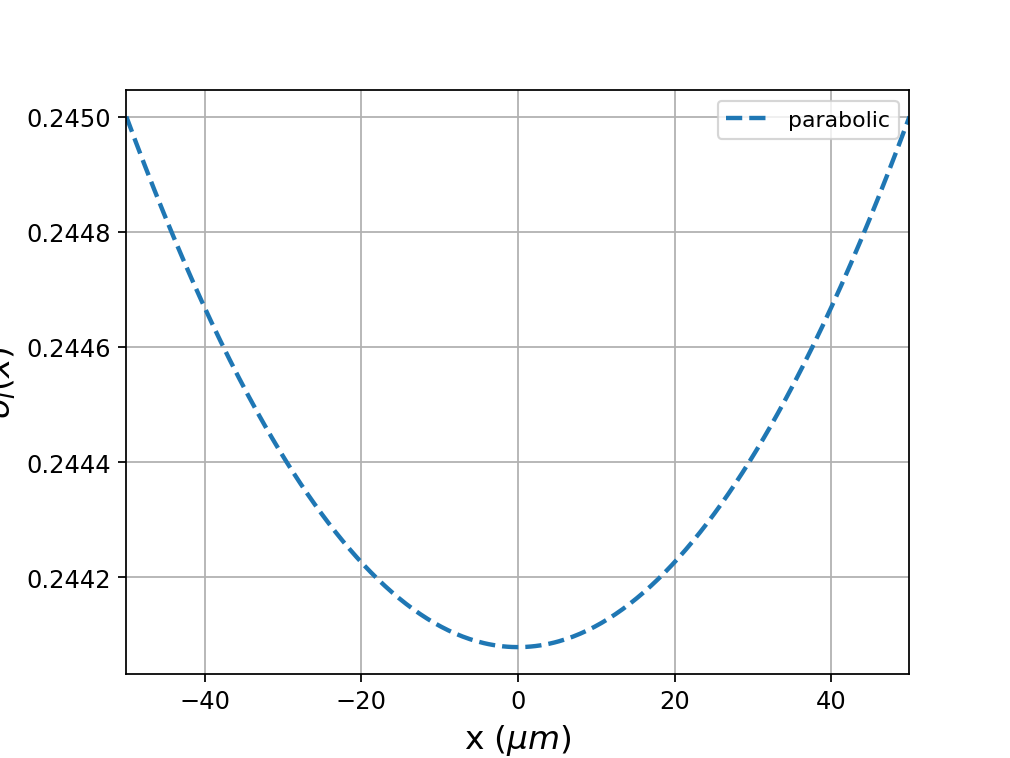

nu_kin_mlyperus = 0.13113929357182705 monolayers/us
nmid = 167
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3003003003003003
sigma_0 = 0.2
sigmaIcorner = 0.245
center reduction = 0.376 %
c_r = 0.00376 dimensionless
max growth rate = 9.638738077529288 um/sec
min growth rate = 1.7703804632196645 um/sec
nu_kin = 39.341788071548116 um/sec
dx = 0.3003003003003003
L = 50 micrometers
nx = 334
tau_eq = 1 microseconds


In [446]:
# Diffusion coefficient
# D = 1.9e-2 # micrometers^2/microsecond
# D = 1e-2 # micrometers^2/microsecond
# D = 2e-3 # micrometers^2/microsecond
# D = 2e-3 # micrometers^2/microsecond
# D = 7e-3 # micrometers^2/microsecond
# D = 1.5e-3 # micrometers^2/microsecond
# D = 1e-3 # micrometers^2/microsecond
# D = 5e-4 # micrometers^2/microsecond
# D = 4e-4 # micrometers^2/microsecond
# D = 3e-4 # micrometers^2/microsecond
# D = 2e-4 # micrometers^2/microsecond
# D = 1e-4 # micrometers^2/microsecond
# D = 7e-5 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond
# Doverdeltax2 = D/deltax**2

# Deposition rate
# nu_kin = 7.5 # microns/second - about right for 240 K
# nu_kin = 10 # microns/second - about right for 240 K
# nu_kin = 15 # microns/second - about right for 240 K
# nu_kin = 20 # microns/second - about right for 240 K
# nu_kin = 25 # microns/second - about right for 240 K
# nu_kin = 30 # microns/second - about right for 240 K
# nu_kin = 34 # microns/second - about right for 240 K
# nu_kin = 50 # microns/second - between 240 and 260 K
# nu_kin = 75 # microns/second - between 240 and 260 K
# nu_kin = 80 # microns/second - between 240 and 260 K
# nu_kin = 90 # microns/second - between 240 and 260 K
# nu_kin = 100 # microns/second - between 240 and 260 K
# nu_kin = 200 # microns/second - between 240 and 260 K
# nu_kin = 250 # microns/second - between 240 and 260 K
# nu_kin = 300 # microns/second - about right for 260 K
# nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
# sigmaIcorner = -0.5 # Must be bigger than sigma0 to get growth (unstable)
# sigmaIcorner = -0.4 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.3 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.2 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.1 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.05 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.03 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.02 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.01 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.18 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.191 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.192 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.193 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.194 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.195 # Must be bigger than sigma0 to get growth (unstable)
# sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.21 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.24 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.25 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.275 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.3 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.4 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.6 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.7 # Must be bigger than sigma0 to get growth 

# center_reduction = 0.25 # In percent
# center_reduction = 0.5 # In percent
# center_reduction = .1 # In percent
# center_reduction = -0.179 + 0.0266*L # Old parameterization

# Longer vaporfield trajectory gave -3.06327719e-02  6.47258001e-03 -1.35639017e-07
# center_reduction = -3.78257863e-02 +7.08508748e-03*L -2.20708650e-05*L**2 # Revised parameterization based on vaporfield_2d_newg

# Diffusion coefficient scaled for this time step and space step

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid, sigmaI_parabolic, '--',lw=linewidth,label='parabolic')
plt.xlim([-xmid,xmid])
plt.legend()
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# Integrator
# odemethod ='Radau' # much too slow (implicit)
# odemethod ='BDF' # still slow (implicit), faster than Radau, results closest to DOP853 and LSODA
# odemethod ='DOP853' # slowest of explicit methods
odemethod ='LSODA' # results are a lot like DOP853, but faster
# odemethod ='RK45' # faster, but results look different from LSODA
# odemethod ='RK23' # fastest, produces V-shaped profiles

# Reporting
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')
print("nx =", nx)
print('tau_eq =', tau_eq, 'microseconds')

### This is the 0-d run

In [447]:
# Time steps
ntimes = 200
tlast = 1000
tkeep_0Darr = np.linspace(0,tlast,ntimes)

# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus, tau_eq])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 0
NQLL_init_0D = ds.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Solve
Ntotkeep_0D, NQLLkeep_0D = ds.run_f0d(NQLL_init_0D,Ntot_init_0D,tkeep_0Darr,params,odemethod)
Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


### Analysis of the 0-d run

0-D Modeled growth rate, um/s 3.8283836371483178
0-D Modeled growth rate, ml/us 0.012761278790494393
0-D Modeled alpha 0.3971872257918697


<IPython.core.display.Javascript object>


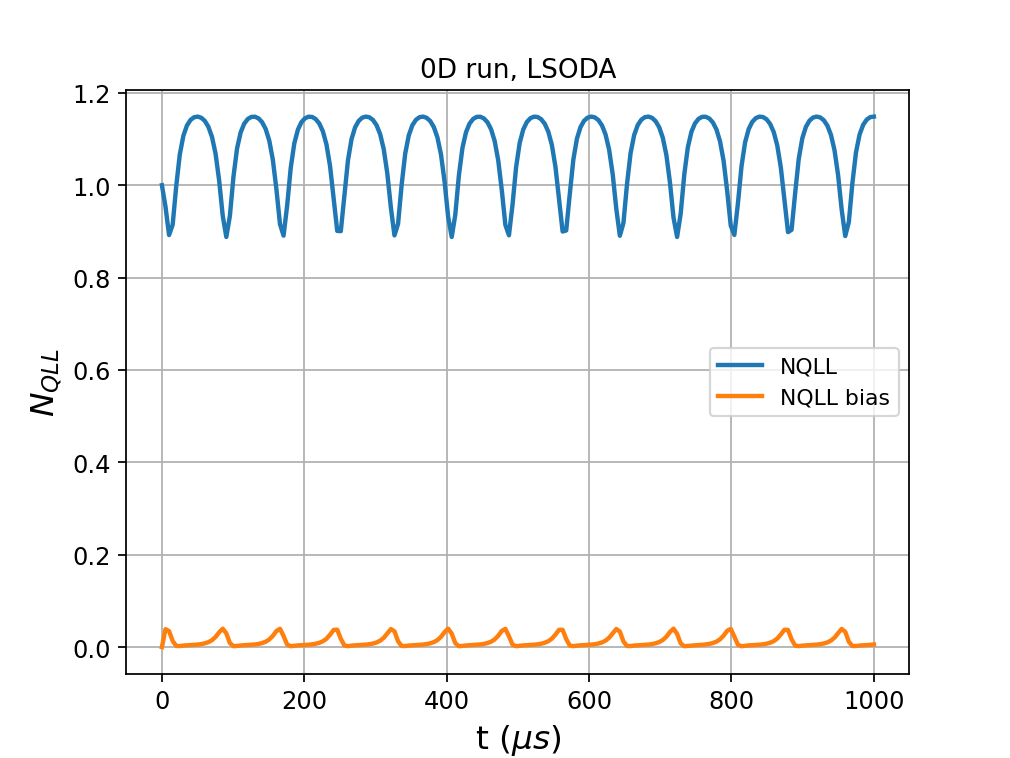

In [448]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tkeep_0Darr[-1] # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run, '+odemethod

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0Darr,NQLLkeep_0D,lw=linewidth,label='NQLL')
plt.plot(tkeep_0Darr,NQLLkeep_0D-ds.getNQLL(Ntotkeep_0D,Nstar,Nbar),lw=linewidth,label='NQLL bias')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)
plt.legend()

### This is the 1-d run

In [449]:
# Time steps
ntimes = 400
tlast = tlast_msec * 1000
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Bundle parameters for ODE solver
scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Solve
Ntotkeep_1D, NQLLkeep_1D = ds.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,scalar_params,sigmaI,odemethod)
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

dt = 1750.050235325047
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


### Analysis of the 1-d run

In [450]:
# Stats
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
delta_alpha = (alpha_1D-alpha_0D)/alpha_0D*100; 
print('Analysis of growth rates relative to 0D system')
print("    1D, 0D alpha =", alpha_1D, alpha_0D)
if delta_Ntot_1D > 0: # Growing
    if delta_alpha < 0:
        print("    1D growth is slower by:", -int(delta_alpha*100)/100,'%')
    else:
        print("    1D growth is faster by:", int(delta_alpha*100)/100,'%')
else: # Ablating
    if delta_alpha < 0:
        print("    1D ablation is slower by:", -int(delta_alpha*100)/100,'%')
    else:
        print("    1D ablation is faster by:", int(delta_alpha*100)/100,'%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Horizontal speed of layers
HLS = growthrate_1D_mlyperus*L
print('horizontal layer speed (micrometers/microsecond) =',HLS)

# Other statistics prep
lastfraction = 0.3

# Graphics prep
title = 'D='+str(D)+', '+odemethod + ', tau='+str(tau_eq)+', $\sigma_I=$'+str(sigmaIcorner)

1-D growth rate, ml/us 0.012508762646210807
1-D growth rate, um/s 3.752628793863242
1-D alpha 0.3893278107236584
Analysis of growth rates relative to 0D system
    1D, 0D alpha = 0.3893278107236584 0.3971872257918697
    1D growth is slower by: 1.97 %
Libbrecht's predicted growth rate 1.9470081400058181 um/s
Libbrecht's predicted alpha 0.20199824129933175
horizontal layer speed (micrometers/microsecond) = 0.6254381323105404


<IPython.core.display.Javascript object>


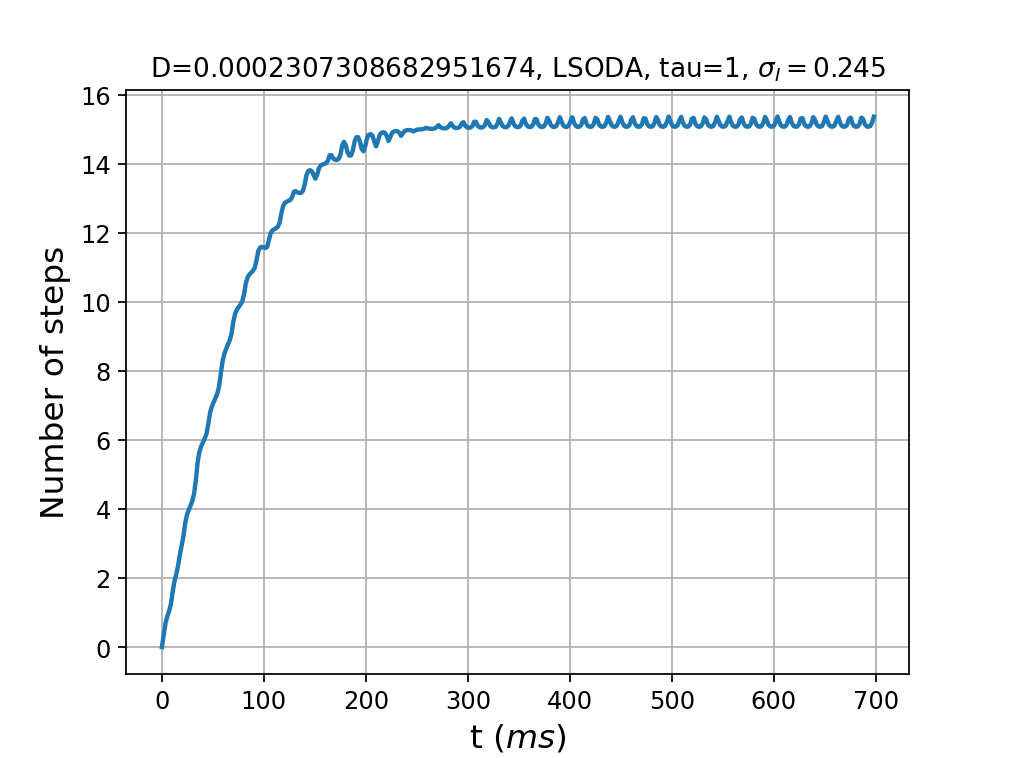

nsteps average of last 30.0 % ( 120 points) = 15.165984490197202
estimated lambda = 3.296851584697213
estimated layer residence time (microseconds) = 5.271267315470096


In [451]:
# # Plot number of steps over time (with index on the x-axis)
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# plt.plot(f,lw=linewidth)
# plt.xlabel('index',fontsize=fontsize)
# plt.ylabel('Number of steps',fontsize=fontsize)
# plt.title(title)
# plt.grid('on')
# # plt.xlim([550,620])

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
plt.xlabel(r't ($m s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')
itimes_almost_end = int(ntimes*(1-lastfraction))
nsteps_ss = np.mean(f[itimes_almost_end:-1])
print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
lambda_average = L/nsteps_ss
print('estimated lambda =', lambda_average)
residence_time = lambda_average/HLS
print('estimated layer residence time (microseconds) =',residence_time)

<IPython.core.display.Javascript object>


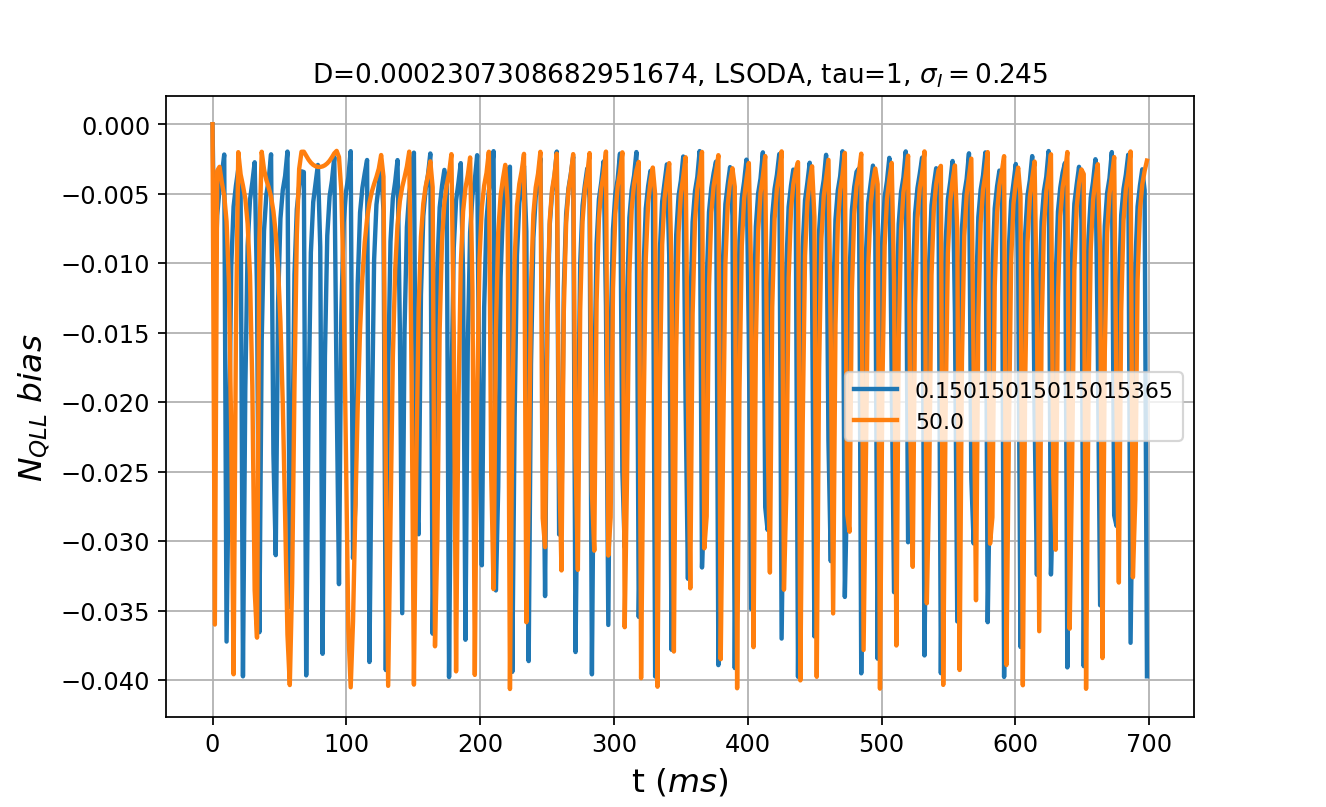

<IPython.core.display.Javascript object>


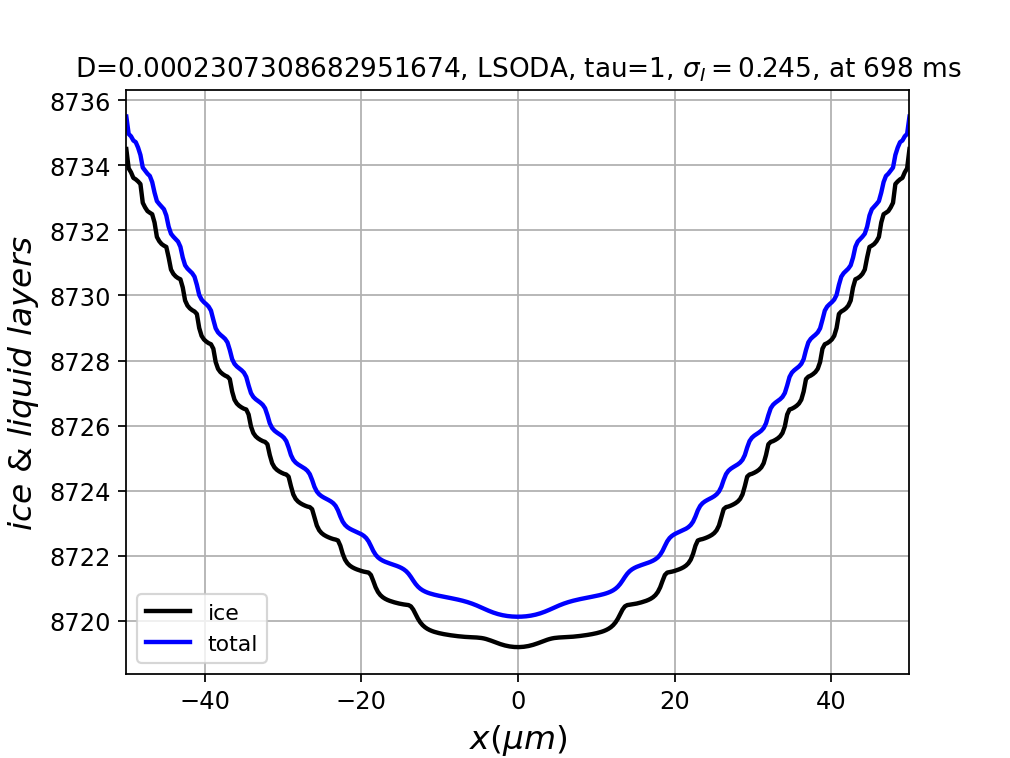

<IPython.core.display.Javascript object>


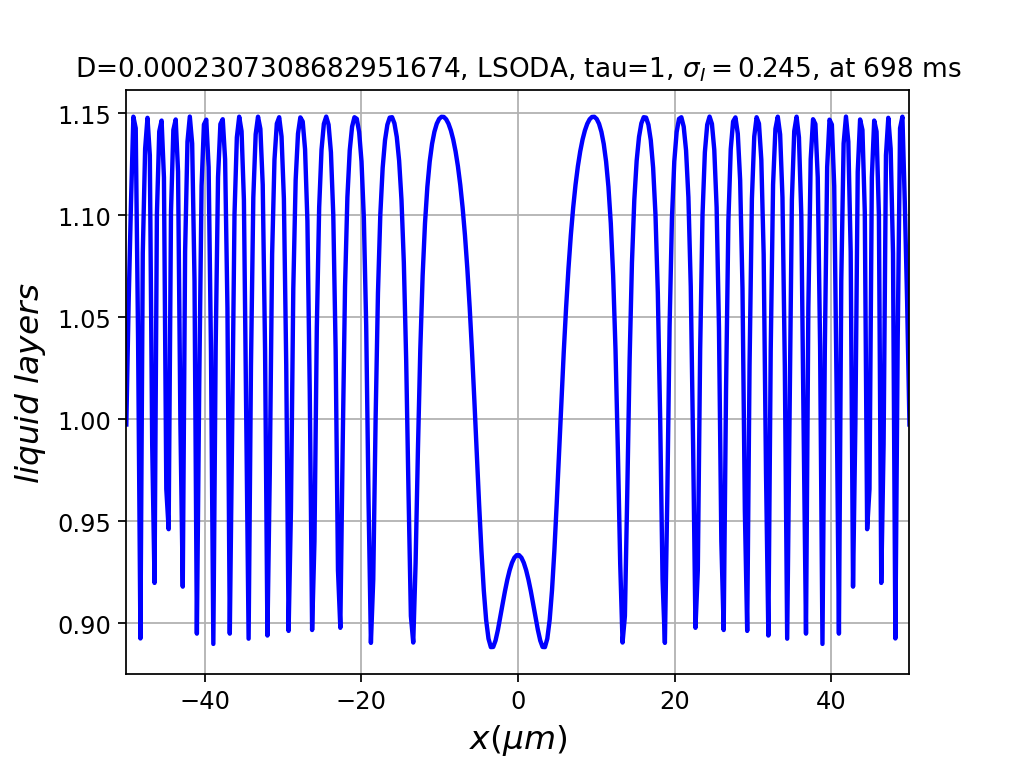

In [452]:
# # Plot number of steps as vertical distance over time
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# f *= nmpermonolayer
# plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
# plt.ylabel(r'vertical relief ($nm$)',fontsize=fontsize)
# plt.title(title)
# plt.grid('on')

# Plot NQLL over time
iposition1 = nmid; NQLL_in_equilibrium_with_Ntot_1 = ds.getNQLL(Ntotkeep_1D[:,iposition1],Nstar,Nbar)
iposition2 = -1;   NQLL_in_equilibrium_with_Ntot_2 = ds.getNQLL(Ntotkeep_1D[:,iposition2],Nstar,Nbar)
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_1-NQLLkeep_1D[:,iposition1],lw=linewidth,label=str(x[iposition1]-xmid))
plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_2-NQLLkeep_1D[:,iposition2],lw=linewidth,label=str(x[iposition2]-xmid))
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.xlabel(r't ($m s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} \ bias$',fontsize=fontsize)
plt.title(title)
plt.legend()
plt.grid('on')

# Plot ice and total
itime = -1
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[itime,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[itime,:], 'b', label='total', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
plt.grid('on')

# Plot liquid
itime = -1
plt.figure()
plt.plot(x-xmid, NQLLkeep_1D[itime,:], 'b', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
plt.grid('on')

### Perturbation 1
This takes the original flat state, runs it with a sinusoidal sigmaI, then does the specified sigmaI.

In [453]:
Iwantperturbation1 = False
if Iwantperturbation1:
    
    mode = 4
    sigmaI_perturbed = -(np.cos((x-xmid)/xmid*np.pi*mode)*0.0001+sigmaI)
    
    # Here's the first perturbation
    tlast_perturbed = tlast
    ntimes_perturbed = int(ntimes/tlast*tlast_perturbed)
    tkeep_perturbed = np.linspace(0,tlast_perturbed,ntimes_perturbed)
    print('dt =', tkeep_perturbed[1]-tkeep_perturbed[0])

    # Solve
    Ntotkeep_perturbed, NQLLkeep_perturbed = ds.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_perturbed,scalar_params,sigmaI_perturbed,odemethod)
    Nicekeep_perturbed = Ntotkeep_perturbed-NQLLkeep_perturbed
    
    # Here's the second perturbation
    deltat_perturbed2 = tlast
    tlast_perturbed2 = tlast + deltat_perturbed2
    ntimes_perturbed2 = int(ntimes/tlast*deltat_perturbed2)
    tkeep_perturbed2 = np.linspace(tlast,tlast_perturbed2,ntimes_perturbed2)
    print('dt =', tkeep_perturbed2[1]-tkeep_perturbed2[0])

    # Solve
    Ntotkeep_perturbed2, NQLLkeep_perturbed2 = ds.run_f1d(NQLLkeep_perturbed[-1,:],Ntotkeep_perturbed[-1,:],tkeep_perturbed2,scalar_params,sigmaI,odemethod)
    Nicekeep_perturbed2 = Ntotkeep_perturbed2-NQLLkeep_perturbed2
    

In [454]:
if Iwantperturbation1:
    
    # Plot the supersaturation profile
    sizemag = 1.5
    fig, axs = plt.subplots(2)
    fig.suptitle(r'$\sigma_I$ (%)',fontsize=fontsize*sizemag)
    rcParams['xtick.labelsize'] = ticklabelsize*sizemag
    rcParams['ytick.labelsize'] = ticklabelsize*sizemag
    axs[0].plot(x-xmid,sigmaI*100, 'b', lw=linewidth, label = r'$\sigma_I$ (%)')
    axs[0].set_xlim([-xmid,xmid])
    axs[0].set_ylabel(r'$\sigma_I$ (%)',fontsize=fontsize*sizemag)
    axs[0].set_xticks([])
    axs[1].plot(x-xmid,sigmaI_perturbation*100, 'gray', label = 'ablating perturbation', lw=linewidth)
    axs[1].set_xlim([-xmid,xmid])
    axs[1].set_xlabel(r'x ($\mu m$)',fontsize=fontsize*sizemag)
    axs[1].legend()

    # Plot number of steps over time
    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    timearray = tkeep_1Darr/1e3
    plt.plot(timearray,f,lw=linewidth)
    f = np.max(Ntotkeep_perturbed,axis=1) - np.min(Ntotkeep_perturbed,axis=1)
    timearray = (tkeep_1Darr+tlast)/1e3
    plt.plot(timearray,f,lw=linewidth,color='gray')
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('Number of steps',fontsize=fontsize)
    plt.title(title)
    plt.grid('on')
    
    # Plot ice and total
    itime = -1
    plt.figure()
    plt.plot(x-xmid, Nicekeep_perturbed[itime,:], 'k', label='ice', lw=linewidth)
    plt.plot(x-xmid, Ntotkeep_perturbed[itime,:], 'b', label='total', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.legend()
    plt.title(title+', at '+str(int(tkeep_perturbed[itime]/1e3))+' ms')
    plt.grid('on')
    
    # Plot liquid
    plt.figure()
    plt.plot(x-xmid, NQLLkeep_perturbed[itime,:], 'b', label='liquid', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.title(title+', at '+str(int(tkeep_perturbed[itime]/1e3))+' ms')
    plt.grid('on')
        
    # Plot number of steps over time
    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
    
    f = np.max(Ntotkeep_perturbed,axis=1) - np.min(Ntotkeep_perturbed,axis=1)
    plt.plot(tkeep_perturbed/1e3,f,lw=linewidth,color='gray')
    
    f = np.max(Ntotkeep_perturbed2,axis=1) - np.min(Ntotkeep_perturbed2,axis=1)
    plt.plot(tkeep_perturbed2/1e3,f,lw=linewidth,color='g')
    
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('Number of steps',fontsize=fontsize)
    plt.title(title)
    plt.grid('on')
    
    # Plot ice and total
    itime = -1
    plt.figure()
    plt.plot(x-xmid, Nicekeep_perturbed2[itime,:], 'k', label='ice', lw=linewidth)
    plt.plot(x-xmid, Ntotkeep_perturbed2[itime,:], 'b', label='total', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.legend()
    plt.title(title+', at '+str(int(tkeep_perturbed2[itime]/1e3))+' ms')
    plt.grid('on')

### Perturbation 2
This picks up from the previous steady state, runs it with a sinusoidal sigmaI perturbation, then does the specified sigmaI again

In [455]:
Iwantperturbation2 = False
if Iwantperturbation2:
    
    mode = 4
    sigmaI_perturbed = -(np.cos((x-xmid)/xmid*np.pi*mode)*0.0001+sigmaI)
    
    # Here's the first perturbation
    deltat_perturbed1 = tlast
    tlast_perturbed1 = tkeep_1Darr[-1] + deltat_perturbed1
    ntimes_perturbed1 = int(ntimes/tlast*deltat_perturbed1)
    tkeep_perturbed1 = np.linspace(tkeep_1Darr[-1],tlast_perturbed1,ntimes_perturbed1)
    print('dt =', tkeep_perturbed1[1]-tkeep_perturbed1[0])
    Ntotkeep_perturbed1, NQLLkeep_perturbed1 = ds.run_f1d(NQLLkeep_1D[-1,:],Ntotkeep_1D[-1,:],tkeep_perturbed1,scalar_params,sigmaI_perturbed,odemethod)
    Nicekeep_perturbed1 = Ntotkeep_perturbed-NQLLkeep_perturbed
    
    # Here's the second perturbation
    deltat_perturbed2 = tlast
    tlast_perturbed2 = tkeep_perturbed1[-1] + deltat_perturbed2
    ntimes_perturbed2 = int(ntimes/tlast*deltat_perturbed2)
    tkeep_perturbed2 = np.linspace(tkeep_perturbed1[-1],tlast_perturbed2,ntimes_perturbed2)
    print('dt =', tkeep_perturbed2[1]-tkeep_perturbed2[0])
    Ntotkeep_perturbed2, NQLLkeep_perturbed2 = ds.run_f1d(NQLLkeep_perturbed1[-1,:],Ntotkeep_perturbed1[-1,:],tkeep_perturbed2,scalar_params,sigmaI,odemethod)
    Nicekeep_perturbed2 = Ntotkeep_perturbed2-NQLLkeep_perturbed2

In [456]:
if Iwantperturbation2:
    
    # Plot the supersaturation profile
    sizemag = 1.5
    fig, axs = plt.subplots(2)
    fig.suptitle(r'$\sigma_I$ (%)',fontsize=fontsize*sizemag)
    rcParams['xtick.labelsize'] = ticklabelsize*sizemag
    rcParams['ytick.labelsize'] = ticklabelsize*sizemag
    axs[0].plot(x-xmid,sigmaI*100, 'b', lw=linewidth, label = 'typical growth profile')
    axs[0].set_xlim([-xmid,xmid])
    axs[0].legend()
    axs[0].set_xticks([])
    axs[1].plot(x-xmid,-sigmaI*100, 'k', label = 'typical ablation profile', lw=linewidth)
    axs[1].plot(x-xmid,sigmaI_perturbation*100, 'gray', label = 'perturbing ablation', lw=linewidth)
    axs[1].set_xlim([-xmid,xmid])
    axs[1].set_xlabel(r'x ($\mu m$)',fontsize=fontsize*sizemag)
    axs[1].legend()
    
    # Plot number of steps over time
    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    plt.plot(tkeep_1Darr/1e3,f,lw=linewidth,label='growing (sigmaD > 0)')
    
    f = np.max(Ntotkeep_perturbed1,axis=1) - np.min(Ntotkeep_perturbed1,axis=1)
    plt.plot(tkeep_perturbed1/1e3,f,lw=linewidth,color='gray',label='ablating (sigmaD<0)')
    
    f = np.max(Ntotkeep_perturbed2,axis=1) - np.min(Ntotkeep_perturbed2,axis=1)
    plt.plot(tkeep_perturbed2/1e3,f,lw=linewidth,color='g',label='growing (sigmaD > 0 restored)')
    
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('Number of steps',fontsize=fontsize)
    plt.title(title)
    plt.grid('on')
    plt.legend()
    
    # Plot ice and total
    itime = 120
    plt.figure()
    plt.plot(x-xmid, Nicekeep_perturbed1[itime,:], 'k', label='ice', lw=linewidth)
    plt.plot(x-xmid, Ntotkeep_perturbed1[itime,:], 'b', label='total', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.legend()
    plt.title(title+', at '+str(int(tkeep_perturbed1[itime]/1e3))+' ms')
    plt.grid('on')
    bottom = np.min(Nicekeep_perturbed1[itime,:])-4
    plt.ylim(bottom,bottom+10)
    
    # Plot ice and total
    itime = -1
    plt.figure()
    plt.plot(x-xmid, Nicekeep_perturbed2[itime,:], 'k', label='ice', lw=linewidth)
    plt.plot(x-xmid, Ntotkeep_perturbed2[itime,:], 'b', label='total', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.legend()
    plt.title(title+', at '+str(int(tkeep_perturbed2[itime]/1e3))+' ms')
    plt.grid('on')

### Perturbation 2
This takes the last state of the system, perturbs it with a sinusoidal sigmaI, then switches back to the original sigmaI

In [457]:
# # Calculate sigma_m
# sigma_m = ds.getsigma_m(NQLLkeep_1D[itime,:],Nbar,Nstar,sigmaI,sigma0)
# # sigma_m_perturbed = ds.getsigma_m(NQLLkeep_1D[itime,:],Nbar,Nstar,sigmaI_perturbed,sigma0)
# sigma_m_perturbed = ds.getsigma_m(NQLLkeep_perturbed[itime,:],Nbar,Nstar,sigmaI_perturbed,sigma0)
# mysigma_m = getsigma_m(NQLLkeep_1D[itime,:],Nbar,Nstar,sigmaI,sigma0,.997,-.0002)


# # Plot differences in sigma_m
# plt.figure()
# plt.plot(x-xmid, sigma_m_perturbed-sigma_m, lw=linewidth,label='perturbed - original')
# plt.plot(x-xmid, mysigma_m-sigma_m, lw=linewidth,label='scaled - original')
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_m$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
# plt.grid('on')
# plt.legend()

# # Plot sigma_m
# plt.figure()
# plt.plot(x-xmid, sigma_m, lw=linewidth,label='original')
# plt.plot(x-xmid, sigma_m_perturbed, 'b', lw=linewidth,label='perturbed')
# plt.plot(x-xmid, mysigma_m, '--', lw=linewidth, label='scaled')
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_m$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
# plt.grid('on')
# plt.legend()


In [458]:
# Iwantperturbations = True
# if Iwantperturbations:
    
#     sigmaIcorner = 0.275 # Must be bigger than sigma0 to get growth
#     # Overlying supersaturation
#     sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
#     sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
#     # sigmaIstyle = 'sinusoid'
#     sigmaIstyle = 'parabolic'
#     if sigmaIstyle=='sinusoid':
#         sigmaI_perturbed = sigmaI_sinusoid
#     elif sigmaIstyle=='parabolic':
#         sigmaI_perturbed = sigmaI_parabolic
#     else:
#         print('bad choice')
#     plt.figure()
#     plt.plot(x-xmid, sigmaI_parabolic, '--', \
#              x-xmid, sigmaI_perturbed, \
#              lw=linewidth)
#     plt.xlim([-xmid,xmid])
#     plt.legend(['starting','perturbed'])
#     plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
#     plt.grid('on')

#     # Make a copy of the last state
#     Ntot_init_perturbed = Ntotlast
#     NQLL_init_perturbed = ds.getNQLL(Ntot_init_perturbed,Nstar,Nbar)
#     Nice_init_perturbed = Ntot_init_perturbed - NQLL_init_perturbed
#     ylast = np.array([NQLL_init_perturbed, Ntot_init_perturbed])
#     ylast = np.reshape(ylast,2*nx)
    
#     # Accumulators
#     tkeep_perturbed = []
#     ykeep_perturbed = []
#     tlast = t_init

#     # Decide how long to integrate
#     countermax_perturbed = 50
#     counter = 0
#     layer = 0
#     ttot = 0.0
    
#     # Time steps
#     t_init = 0.0
#     deltat_perturbed = deltat_0D*10
#     tinterval = [t_init, t_init+deltat_perturbed]
#     print('deltat_perturbed =', deltat_perturbed)
        
#     while True:
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI_perturbed),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
#         tlast += deltat_1D

#         # Stuff into keeper arrays
#         ykeep_perturbed.append(ylast)
#         tkeep_perturbed.append(tlast)

#         # Make some local copies
#         ttot += deltat_1D

#         # Update counters and see whether to break
#         NQLLlast_perturbed, Ntotlast_perturbed = np.reshape(ylast,(2,nx))
#         minpoint = min(Ntotlast_perturbed)
#         maxpoint = max(Ntotlast_perturbed)
#         #print(counter, int(Ntotlast_perturbed[0]), maxpoint-minpoint)
#         counter += 1
#         if counter > countermax_perturbed-1:
#                 break
                
#     # Plot NQLL (last and perturbed)
#     plt.figure()
#     plt.plot(x-xmid, NQLLlast_perturbed, 'r', label='Perturbed', lw=linewidth)
#     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
#     plt.xlim([-xmid, xmid])
#     rcParams['xtick.labelsize'] = ticklabelsize 
#     rcParams['ytick.labelsize'] = ticklabelsize
#     plt.grid('on')
#     plt.title('After '+str(counter)+' iterations')

# #     # Plot ice and total (last and perturbed)
# #     Nicelast_perturbed = Ntotlast_perturbed - NQLLlast_perturbed
# #     plt.figure()
# #     plt.plot(x-xmid, Nicelast_perturbed, 'k--', lw=linewidth)
# #     plt.plot(x-xmid, Ntotlast_perturbed, 'b--', lw=linewidth)
# #     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# #     plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# #     plt.xlim([-xmid, xmid])
# #     rcParams['xtick.labelsize'] = ticklabelsize 
# #     rcParams['ytick.labelsize'] = ticklabelsize
# #     plt.grid('on')
# #     plt.title('After '+str(counter)+' iterations')


### Sinusoidal perturbations to steady state
I wrote this code, and it works, I'm just not sure what we can learn from it.

In [459]:
# mode = 1
# amp = -Nbar/50
# Ntot_perturbation = np.cos((x-xmid)/xmid*np.pi*mode)*amp
# Ntot_init_perturbed = Ntotlast + Ntot_perturbation
# NQLL_init_perturbed = ds.getNQLL(Ntot_init_perturbed,Nstar,Nbar)
# Nice_init_perturbed = Ntot_init_perturbed - NQLL_init_perturbed

# # Plot NQLL (last and perturbed)
# plt.figure()
# plt.plot(x-xmid, NQLLlast, 'b', label='last NQLL', lw=linewidth)
# plt.plot(x-xmid, NQLL_init_perturbed, 'r', label='Perturbed', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.grid('on')
# plt.title('Starting perturbed state')

# # # Plot ice and total (last and perturbed)
# # plt.figure()
# # plt.plot(x-xmid, Nicelast, 'k', label='ice', lw=linewidth)
# # plt.plot(x-xmid, Ntotlast, 'b', label='total', lw=linewidth)
# # plt.plot(x-xmid, Nice_init_perturbed, 'k--', lw=linewidth)
# # plt.plot(x-xmid, Ntot_init_perturbed, 'b--', lw=linewidth)
# # plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# # plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# # plt.xlim([-xmid, xmid])
# # rcParams['xtick.labelsize'] = ticklabelsize 
# # rcParams['ytick.labelsize'] = ticklabelsize
# # plt.legend()
# # plt.grid('on')
# # plt.title('Starting perturbed state')

# Iwantperturbations = True
# if Iwantperturbations:

#     # Set up initial condidions
#     ylast = np.array([NQLL_init_perturbed, Ntot_init_perturbed])
#     ylast = np.reshape(ylast,2*nx)
    
#     # Accumulators
#     tkeep_perturbed = []
#     ykeep_perturbed = []
#     tlast = t_init

#     # Decide how long to integrate
#     countermax_perturbed = 50
#     counter = 0
#     layer = 0
#     ttot = 0.0
        
#     while True:
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
#         tlast += deltat_1D

#         # Stuff into keeper arrays
#         ykeep_perturbed.append(ylast)
#         tkeep_perturbed.append(tlast)

#         # Make some local copies
#         ttot += deltat_1D

#         # Update counters and see whether to break
#         NQLLlast_perturbed, Ntotlast_perturbed = np.reshape(ylast,(2,nx))
#         minpoint = min(Ntotlast_perturbed)
#         maxpoint = max(Ntotlast_perturbed)
#         #print(counter, int(Ntotlast_perturbed[0]), maxpoint-minpoint)
#         counter += 1
#         if counter > countermax_perturbed-1:
#                 break
#     # Plot NQLL (last and perturbed)
#     plt.figure()
#     plt.plot(x-xmid, NQLLlast_perturbed, 'r', label='Perturbed', lw=linewidth)
#     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
#     plt.xlim([-xmid, xmid])
#     rcParams['xtick.labelsize'] = ticklabelsize 
#     rcParams['ytick.labelsize'] = ticklabelsize
#     plt.grid('on')
#     plt.title('After '+str(counter)+' iterations')

# #     # Plot ice and total (last and perturbed)
# #     Nicelast_perturbed = Ntotlast_perturbed - NQLLlast_perturbed
# #     plt.figure()
# #     plt.plot(x-xmid, Nicelast_perturbed, 'k--', lw=linewidth)
# #     plt.plot(x-xmid, Ntotlast_perturbed, 'b--', lw=linewidth)
# #     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# #     plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# #     plt.xlim([-xmid, xmid])
# #     rcParams['xtick.labelsize'] = ticklabelsize 
# #     rcParams['ytick.labelsize'] = ticklabelsize
# #     plt.grid('on')
# #     plt.title('After '+str(counter)+' iterations')


### Lambda fitting
If we say, for growth,

$$
\lambda_g = \lambda_{o,g} \times \bigl (1 - exp(-{1 \over (\sigma_{I,corner} - \sigma_o) x_{o,g}}) \bigr )
$$

then $\lambda_{o,g}$ is the limit as $\sigma_{I,corner} → \sigma_o$, and $x_{o,g}$ is the associated exponential decay constant. 

Likewise, for ablation (with $\sigma_{I,corner}<0$)

$$
\lambda_a = \lambda_{o,a} \times \bigl (1 - exp({1 \over  \sigma_{I,corner} x_{o,a}}) \bigr )
$$

In [460]:
# # Exploring the dependence of lambda on parameters
# sigmaIcorner_growth = np.array([
# 0.2225,
# 0.2250,
# 0.2300,
# 0.2400,
# 0.2600,
# 0.2800,
# 0.3000,
# 0.3500,
# 0.4000,
# 0.5000,
# 0.6000])
# lambda_growth = np.array([
# 9.174,
# 9.158,
# 9.058,
# 8.772,
# 8.143,
# 7.508,
# 6.944,
# 5.807,
# 4.955,
# 3.788,
# 3.019])
# sigmaIcorner_ablate = np.array([
# -0.5500,
# -0.5000,
# -0.4500,
# -0.4000,
# -0.3000,
# -0.2500,
# -0.2000,
# -0.1500,
# -0.1250,
# -0.1000,
# -0.0900,
# -0.0800,
# -0.0700,
# -0.0600,
# -0.0500,
# -0.0450,
# -0.0350,
# -0.0250,
# -0.0225])
# lambda_ablate = np.array([
# 2.68,
# 2.97,
# 3.33,
# 3.74,
# 4.93,
# 5.83,
# 7.08,
# 8.93,
# 10.33,
# 12.11,
# 13.02,
# 14.12,
# 15.48,
# 17.06,
# 18.18,
# 20.24,
# 23.26,
# 27.62,
# 29.07])

# sigmaIcorner2_growth = np.array([
# 0.2225,
# 0.2250,
# 0.2400,
# 0.2600,
# 0.3000,
# 0.4000])

# lambda2_growth = np.array([
# 6.25,
# 6.24,
# 6.02,
# 5.60,
# 4.76,
# 3.37])

# sigmaIcorner2_ablate = np.array([
# -0.3000,
# -0.2000,
# -0.1000,
# -0.0500,
# -0.0450,
# -0.0350,
# -0.0250])

# lambda2_ablate = np.array([
# 3.34,
# 4.83,
# 8.32,
# 13.12,
# 13.95,
# 16.08,
# 19.12])

# plt.figure()
# plt.plot(sigmaIcorner_growth, lambda_growth,'o', color='b', label='growth, L=50)')
# plt.plot(sigmaIcorner_ablate, lambda_ablate, 'x', color='r', label='ablation, L=50')
# plt.xlabel(r'$\sigma_{I,corner}$',fontsize=fontsize)
# plt.ylabel(r'$\lambda (\mu m)$',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid('on')
# plt.legend()

# plt.figure()
# xgrowth = 1/(sigmaIcorner_growth-.2)
# plt.plot(xgrowth, lambda_growth,'o', color='b', label='growth, L=50')
# xablate = 1/sigmaIcorner_ablate
# plt.plot(xablate, lambda_ablate,'x', color='r', label='ablation, L=50')

# # Fitting
# def expfun(x,lambda0,x0):
#     return lambda0*(1-np.exp(-x/x0))
# pgrowth,pcov = curve_fit(expfun,xgrowth,lambda_growth,[10,7]);print(pgrowth)
# lambda_growth_fit = expfun(xgrowth,pgrowth[0],pgrowth[1])
# pablate,pcov = curve_fit(expfun,-xablate,lambda_ablate,[38,25]);print(pablate)
# lambda_ablate_fit = expfun(-xablate,pablate[0],pablate[1])

# # Just checking
# plt.plot(xgrowth,lambda_growth_fit)
# plt.plot(xablate,lambda_ablate_fit)
# plt.grid(True)

# # Setting up the figure
# plt.figure()
# plt.xlabel(r'$\sigma_{I,corner}$',fontsize=fontsize)
# plt.ylabel(r'$\lambda (\mu m)$',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid('on')

# # Plots the "experimental" values and the best-fit values
# plt.plot(sigmaIcorner_ablate, lambda_ablate, 'x', color='r', label='ablation, L=50')
# label = 'exp. fit w/$\lambda_{o}=$'+str('{:.0f}'.format(pablate[0]))                                
# plt.plot(sigmaIcorner_ablate, lambda_ablate_fit, '-', color='r', label=label)
# plt.plot(sigmaIcorner_growth, lambda_growth,'o', color='b', label='growth, L=50')
# label = 'exp. fit w/$\lambda_{o}=$'+str('{:.1f}'.format(pgrowth[0]))
# plt.plot(sigmaIcorner_growth, lambda_growth_fit,'-', color='b', label=label)            

# plt.plot(sigmaIcorner2_ablate, lambda2_ablate, '-', color='pink', label='ablation, L=100')
# plt.plot(sigmaIcorner2_growth, lambda2_growth, '-', color='teal', label='growth, L=100')


# # Axis labels, etc.
# plt.legend()

In [461]:
# zparm_growth = np.array([
# 2.43,
# 3.16,
# 5.42,
# 5.42,
# 7.67,
# 9.90,
# 10.85,
# 11.55,
# 12.13,
# 14.85,
# 17.15,
# 20.29,
# 21.69,
# 2.83,
# 4.95,
# 4.43,
# 12.91,
# 19.17,
# 4.29])
# lambda_zparm_growth = np.array([
# 2.84,
# 3.30,
# 6.67,
# 6.51,
# 9.29,
# 12.10,
# 13.16,
# 14.33,
# 14.71,
# 18.02,
# 20.83,
# 24.63,
# 26.32,
# 2.82,
# 5.91,
# 5.25,
# 16.13,
# 23.53,
# 5.09])

# plt.figure()
# plt.plot(zparm_growth, lambda_zparm_growth,'o', color='b')
# p = np.polyfit(zparm_growth,lambda_zparm_growth,1)
# m_g = p[0]; print('m_g = ', m_g)
# b_g = p[1]; print('b_g = ', b_g)
# plt.plot(zparm_growth, np.polyval(p,zparm_growth),color='k')
# plt.xlabel(r'$z-parameter$',fontsize=fontsize)
# plt.ylabel(r'$\lambda (\mu m)$',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid('on')

I think the code below is outdated

In [462]:
# # The time required for an initial gaussian to diffuse
# layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
# t = 1/layer_growth_rate; print('Time to add a layer =', t)
# t = 2.5**2/D; print('Time to diffuse across a terrace =', t)
# t = deltax**2/D; print('Time for equilibration across dx =', t)
# t = 0.001; print('Time for ice-QLL equilibration =', t)

# # How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
# D_old = 2e-6
# D_new = D_old/50**2*100**2; print(D_new)

# # Computing the kinetic deposition velocity ... roughly, 260 
# M = 18 # g/mol
# T = 260 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
# M = 18 # g/mol
# T = 240 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Gladich et al recommendation
# D_Gladich = 0.16e-9 # m^2/s
# D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

In [463]:
# def run_f1d(NQLL_init_1D,Ntot_init_1D,times,scalar_params,sigmaI,odemethod):
#     # Call the ODE solver
#     nt = len(times)
#     nx = len(NQLL_init_1D)
#     ylast = np.array([NQLL_init_1D,Ntot_init_1D])
#     ylast = np.reshape(ylast,2*nx)
#     ykeep_1D = [ylast]

#     for i in range(0,nt-1):

#         # Specify the time interval of this step
#         tinterval = [times[i],times[i+1]]
        
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
        
#         # Stuff into keeper arrays
#         ykeep_1D.append(ylast)
        
#         # Progress reporting
#         print(i/nt*100,'% done')

#     ykeep_1D = np.array(ykeep_1D, np.float64)
#     ykeep_1Darr = np.array(ykeep_1D, np.float64)
#     ykeep_1Darr_reshaped = np.reshape(ykeep_1Darr,(nt,2,nx))
#     Ntotkeep_1D = ykeep_1Darr_reshaped[:,1,:]
#     NQLLkeep_1D = ykeep_1Darr_reshaped[:,0,:]
#     return Ntotkeep_1D, NQLLkeep_1D

In [464]:
hasattr(itime,'units')

False

In [465]:
help(hasattr)

Help on built-in function hasattr in module builtins:

hasattr(obj, name, /)
    Return whether the object has an attribute with the given name.
    
    This is done by calling getattr(obj, name) and catching AttributeError.

